In [5]:
# ===============================
# Multi-Modal Retinal Disease Diagnosis (Kaggle Ready, Dynamic Classes)
# ===============================
import os, glob, cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# 2️⃣ Dataset Loaders
# ===============================
def load_idrid_data(idrid_dir, max_samples=None):
    df = pd.read_csv(os.path.join(idrid_dir, "idrid_labels.csv"))
    fundus_paths, labels = [], []
    img_folder = os.path.join(idrid_dir, "Imagenes", "Imagenes")
    for _, row in df.iterrows():
        filename = str(row["id_code"])
        for ext in [".jpg", ".jpeg"]:
            path = os.path.join(img_folder, filename+ext)
            if os.path.exists(path):
                fundus_paths.append(path)
                labels.append(int(row["diagnosis"]))
                break
    if max_samples:
        fundus_paths, labels = fundus_paths[:max_samples], labels[:max_samples]
    print(f"[IDRiD] {len(fundus_paths)} samples loaded")
    return fundus_paths, labels

def load_duke_oct_data(oct_dir, max_samples=None):
    class_map = {"AMD":0,"DME":1,"NORMAL":2}
    oct_paths, labels = [], []
    for cls in class_map:
        paths = glob.glob(os.path.join(oct_dir, cls,"*.jpg"))
        for p in paths:
            oct_paths.append(p)
            labels.append(class_map[cls])
    if max_samples:
        oct_paths, labels = oct_paths[:max_samples], labels[:max_samples]
    print(f"[DUKE-OCT] {len(oct_paths)} samples loaded")
    return oct_paths, labels

def load_aptos_data(aptos_dir, split="train", max_samples=None):
    csv_map = {"train":"Ill train_1.csv", "val":"Ill valid.csv", "test":"1ll test.csv"}
    img_map = {"train":"train_images","val":"val_images","test":"test_images"}
    df = pd.read_csv(os.path.join(aptos_dir, csv_map[split]))
    fundus_paths, labels = [], []
    for _, row in df.iterrows():
        path = os.path.join(aptos_dir,img_map[split],str(row["id_code"])+".png")
        if os.path.exists(path):
            fundus_paths.append(path)
            labels.append(int(row["diagnosis"]))
    if max_samples:
        fundus_paths, labels = fundus_paths[:max_samples], labels[:max_samples]
    print(f"[APTOS-{split}] {len(fundus_paths)} samples loaded")
    return fundus_paths, labels

# ===============================
# 3️⃣ Multi-Modal Dataset
# ===============================
class MultiModalDataset(Dataset):
    def __init__(self, fundus_paths, oct_paths, clinical_data, labels, transform=None):
        n = min(len(fundus_paths), len(oct_paths), len(clinical_data), len(labels))
        self.fundus_paths = fundus_paths[:n]
        self.oct_paths = oct_paths[:n]
        self.clinical_data = np.array(clinical_data[:n], dtype=np.float32)
        self.labels = np.array(labels[:n], dtype=np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        f_img = cv2.imread(self.fundus_paths[idx])
        f_img = cv2.cvtColor(f_img, cv2.COLOR_BGR2RGB)
        o_img = cv2.imread(self.oct_paths[idx])
        o_img = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)
        if self.transform:
            f_img = self.transform(f_img)
            o_img = self.transform(o_img)
        clinical = torch.tensor(self.clinical_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return f_img, o_img, clinical, label

def build_multimodal_dataset(fundus_paths, oct_paths, labels, num_clinical_features=3):
    n = min(len(fundus_paths), len(oct_paths), len(labels))
    fundus_paths, oct_paths, labels = fundus_paths[:n], oct_paths[:n], labels[:n]
    clinical_data = np.random.randint([40,80,100],[80,200,160], size=(n,num_clinical_features)).astype(np.float32)
    return fundus_paths, oct_paths, clinical_data, labels

# ===============================
# 4️⃣ Image Transform
# ===============================
image_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ===============================
# 5️⃣ Load datasets
# ===============================
fundus_paths, labels = load_idrid_data("/kaggle/input/idrid-dataset")
oct_paths, oct_labels = load_duke_oct_data("/kaggle/input/oct-dataset-duke-srinivasan-2014")
fundus_paths, oct_paths, clinical_data, labels = build_multimodal_dataset(fundus_paths, oct_paths, labels)

# Dynamic num_classes
num_classes = len(np.unique(labels))
print("Detected number of classes:", num_classes)

train_paths_f, val_paths_f, train_paths_o, val_paths_o, train_clin, val_clin, train_labels, val_labels = train_test_split(
    fundus_paths, oct_paths, clinical_data, labels, test_size=0.2, random_state=42
)

train_ds = MultiModalDataset(train_paths_f, train_paths_o, train_clin, train_labels, transform=image_transforms)
val_ds = MultiModalDataset(val_paths_f, val_paths_o, val_clin, val_labels, transform=image_transforms)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

# ===============================
# 6️⃣ Model
# ===============================
class MultiModalNet(nn.Module):
    def __init__(self, num_classes=4, clinical_features=3):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.fundus_backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fundus_fc = nn.Linear(resnet.fc.in_features,128)
        self.oct_branch = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.oct_fc = nn.Linear(32,128)
        self.clinical_fc = nn.Sequential(
            nn.Linear(clinical_features,64), nn.ReLU(), nn.Linear(64,128)
        )
        self.attn = nn.Linear(128*3,3)
        self.fc_shared = nn.Linear(128*3,128)
        self.classifier_cls = nn.Linear(128,num_classes)
        self.classifier_sev = nn.Linear(128,1)

    def forward(self,f,o,c):
        f_feat = self.fundus_fc(self.fundus_backbone(f).view(f.size(0),-1))
        o_feat = self.oct_fc(self.oct_branch(o).view(o.size(0),-1))
        c_feat = self.clinical_fc(c)
        concat = torch.cat([f_feat,o_feat,c_feat],dim=1)
        attn_weights = F.softmax(self.attn(concat),dim=1)
        fused = self.fc_shared(torch.cat([
            attn_weights[:,0:1]*f_feat,
            attn_weights[:,1:2]*o_feat,
            attn_weights[:,2:3]*c_feat
        ],dim=1))
        cls_out = self.classifier_cls(fused)
        sev_out = self.classifier_sev(fused)
        return cls_out, sev_out

def multi_task_loss(cls_pred, sev_pred, cls_true, sev_true, alpha=1.0,beta=0.5):
    loss_cls = F.cross_entropy(cls_pred, cls_true)
    loss_sev = F.mse_loss(sev_pred.squeeze(), sev_true.float())
    return alpha*loss_cls + beta*loss_sev

# ===============================
# 7️⃣ Instantiate Model
# ===============================
model = MultiModalNet(num_classes=num_classes, clinical_features=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
best_val_loss = float("inf")

# ===============================
# 8️⃣ Training Loop (demo 3 epochs)
# ===============================
for epoch in range(3):
    model.train(); train_loss=0
    for f,o,c,y in train_loader:
        f,o,c,y = f.to(device), o.to(device), c.to(device), y.to(device)
        optimizer.zero_grad()
        cls_pred, sev_pred = model(f,o,c)
        sev_true = y.float()
        loss = multi_task_loss(cls_pred, sev_pred, y, sev_true)
        loss.backward(); optimizer.step()
        train_loss += loss.item()*f.size(0)
    train_loss/=len(train_loader.dataset)

    model.eval(); val_loss=0; all_preds=[]; all_labels=[]
    with torch.no_grad():
        for f,o,c,y in val_loader:
            f,o,c,y = f.to(device), o.to(device), c.to(device), y.to(device)
            cls_pred, sev_pred = model(f,o,c)
            sev_true = y.float()
            loss = multi_task_loss(cls_pred, sev_pred, y, sev_true)
            val_loss += loss.item()*f.size(0)
            all_preds.append(cls_pred.argmax(dim=1).cpu().numpy())
            all_labels.append(y.cpu().numpy())
    val_loss/=len(val_loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    print(f"Epoch {epoch+1} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")
    print(classification_report(all_labels, all_preds, digits=4, zero_division=0))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),"best_multimodal_model.pth")
        print("✅ Saved best model!")


Using device: cuda
[IDRiD] 455 samples loaded
[DUKE-OCT] 3231 samples loaded
Detected number of classes: 5


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


Epoch 1 | Train Loss 2.1344 | Val Loss 1.4836
              precision    recall  f1-score   support

           0     0.6667    0.9565    0.7857        23
           1     0.0000    0.0000    0.0000         2
           2     0.5778    0.7027    0.6341        37
           3     0.2500    0.2000    0.2222        15
           4     0.0000    0.0000    0.0000        14

    accuracy                         0.5604        91
   macro avg     0.2989    0.3718    0.3284        91
weighted avg     0.4446    0.5604    0.4931        91

✅ Saved best model!
Epoch 2 | Train Loss 1.3445 | Val Loss 1.4102
              precision    recall  f1-score   support

           0     0.8571    0.7826    0.8182        23
           1     0.0000    0.0000    0.0000         2
           2     0.6000    0.3243    0.4211        37
           3     0.1429    0.0667    0.0909        15
           4     0.3023    0.9286    0.4561        14

    accuracy                         0.4835        91
   macro avg     0.

In [7]:
import shap
import numpy as np
import torch
# ===============================
# 9️⃣ Grad-CAM for Explainability
# ===============================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activation = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        self.model.zero_grad()
        out,_ = self.model(*x)
        pred = out.argmax(dim=1)
        out[:, pred].backward(retain_graph=True)
        pooled_grad = torch.mean(self.gradients, dim=[0,2,3])
        heatmap = torch.mean(self.activation * pooled_grad[None,:,None,None], dim=1).squeeze()
        heatmap = heatmap.detach().cpu().numpy()
        if heatmap.ndim == 0:
            heatmap = heatmap.reshape(1,1)
        return heatmap

# Grad-CAM for fundus & OCT
gradcam_fundus = GradCAM(model, model.fundus_backbone[-1])
gradcam_oct = GradCAM(model, model.oct_branch[0])  # first conv layer

# ===============================
# 10️⃣ SHAP for clinical features
# ===============================


def shap_clinical(model, f_tensor, o_tensor, clinical_sample, num_samples=50):
    """
    Compute SHAP values for clinical features.
    - f_tensor, o_tensor: fixed images (1, C, H, W)
    - clinical_sample: array-like, shape=(num_features,)
    - num_samples: number of perturbed samples for SHAP
    """
    clinical_sample = np.array(clinical_sample)
    # Add small random noise to generate a batch for SHAP
    clinical_batch = np.tile(clinical_sample, (num_samples, 1))
    clinical_batch = clinical_batch + np.random.normal(0, 1e-1, clinical_batch.shape)

    def model_forward(clinical_inputs):
        clinical_inputs = torch.tensor(clinical_inputs, dtype=torch.float32).to(device)
        N = clinical_inputs.size(0)
        with torch.no_grad():
            f_repeat = f_tensor.repeat(N,1,1,1)
            o_repeat = o_tensor.repeat(N,1,1,1)
            cls_out, _ = model(f_repeat, o_repeat, clinical_inputs)
            return cls_out.cpu().numpy()
    
    explainer = shap.Explainer(model_forward, clinical_batch)
    shap_values = explainer(clinical_batch)
    feature_names = [f"Feature {i+1}" for i in range(clinical_sample.shape[0])]
    return shap_values.values.mean(axis=0), feature_names




# ===============================
# 11️⃣ Visualization Function
# ===============================
def visualize_explainability(fundus_img, oct_img, clinical_sample, model, gradcam_f, gradcam_o):
    model.eval()
    f_tensor = image_transforms(fundus_img).unsqueeze(0).to(device)
    o_tensor = image_transforms(oct_img).unsqueeze(0).to(device)
    c_tensor = torch.tensor(np.array([clinical_sample]), dtype=torch.float32).to(device)

    # Predictions
    with torch.no_grad():
        cls_out, sev_out = model(f_tensor, o_tensor, c_tensor)
        pred_class = cls_out.argmax(dim=1).item()
        severity = sev_out.item()
        # Modality attention
        f_feat = model.fundus_fc(model.fundus_backbone(f_tensor).view(1,-1))
        o_feat = model.oct_fc(model.oct_branch(o_tensor).view(1,-1))
        c_feat = model.clinical_fc(c_tensor)
        concat = torch.cat([f_feat,o_feat,c_feat],dim=1)
        attn_weights = F.softmax(model.attn(concat),dim=1).cpu().numpy()[0]

    # Grad-CAM heatmaps
    import cv2
    f_heatmap = cv2.resize(gradcam_f([f_tensor,o_tensor,c_tensor]), (fundus_img.shape[1], fundus_img.shape[0]))
    o_heatmap = cv2.resize(gradcam_o([f_tensor,o_tensor,c_tensor]), (oct_img.shape[1], oct_img.shape[0]))

    # SHAP values
    shap_vals, feature_names = shap_clinical(model, f_tensor, o_tensor, clinical_sample)

    # ===============================
    # Plotting
    # ===============================
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2,3, figure=fig)

    # Fundus Grad-CAM
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(fundus_img)
    ax0.imshow(f_heatmap, cmap='jet', alpha=0.5)
    ax0.set_title("Fundus Grad-CAM")
    ax0.axis('off')

    # OCT Grad-CAM
    ax1 = fig.add_subplot(gs[0,1])
    ax1.imshow(oct_img)
    ax1.imshow(o_heatmap, cmap='jet', alpha=0.5)
    ax1.set_title("OCT Grad-CAM")
    ax1.axis('off')

    # Modality Attention
    ax2 = fig.add_subplot(gs[0,2])
    ax2.bar([f'F','O','C'], attn_weights)
    ax2.set_title("Modality Attention")

    # Clinical SHAP
    ax3 = fig.add_subplot(gs[1,:])
    ax3.bar(feature_names, shap_vals[:, pred_class])
    ax3.set_title("Clinical Feature Importance (SHAP)")
    ax3.set_ylabel("SHAP Value")

    plt.suptitle(f"Predicted Class: {pred_class}, Severity: {severity:.2f}")
    plt.tight_layout()
    plt.show()


ExactExplainer explainer: 51it [00:34,  1.18it/s]                        


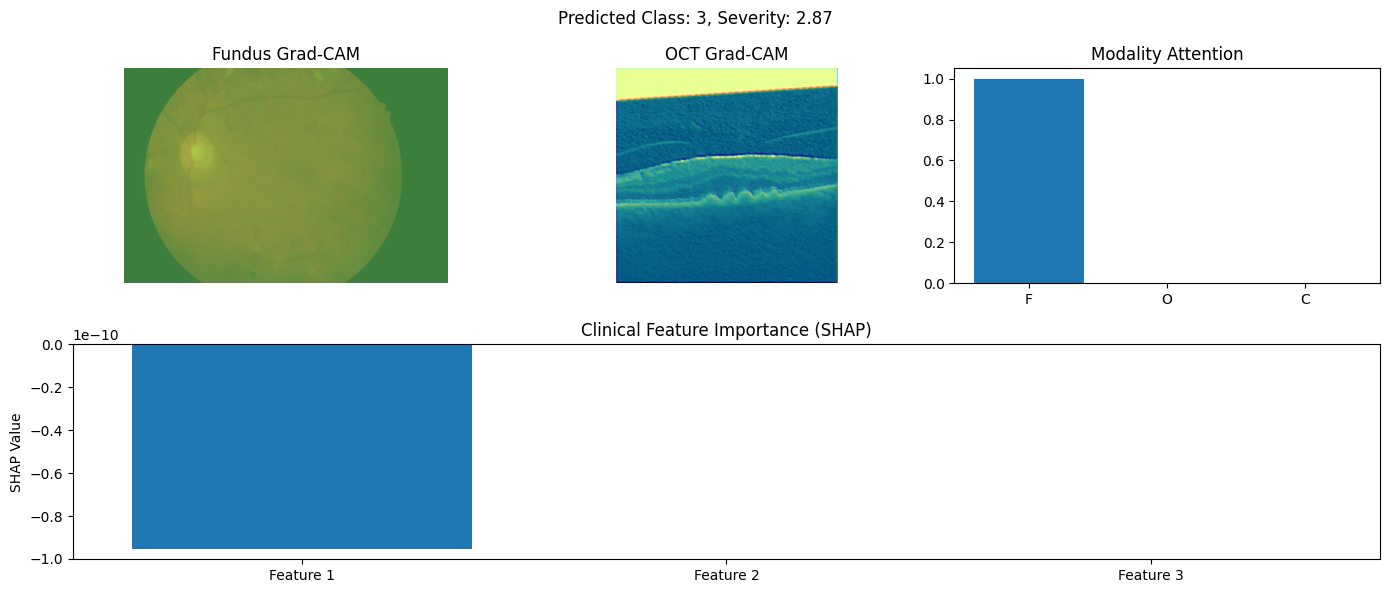

In [8]:
visualize_explainability(
    fundus_img=cv2.imread(train_paths_f[0])[:,:,::-1],
    oct_img=cv2.imread(train_paths_o[0])[:,:,::-1],
    clinical_sample=train_clin[0],
    model=model,
    gradcam_f=gradcam_fundus,
    gradcam_o=gradcam_oct
)


✅ Loaded best model for inference and demo.


ExactExplainer explainer: 51it [00:32,  1.05it/s]                        


<Figure size 640x480 with 0 Axes>

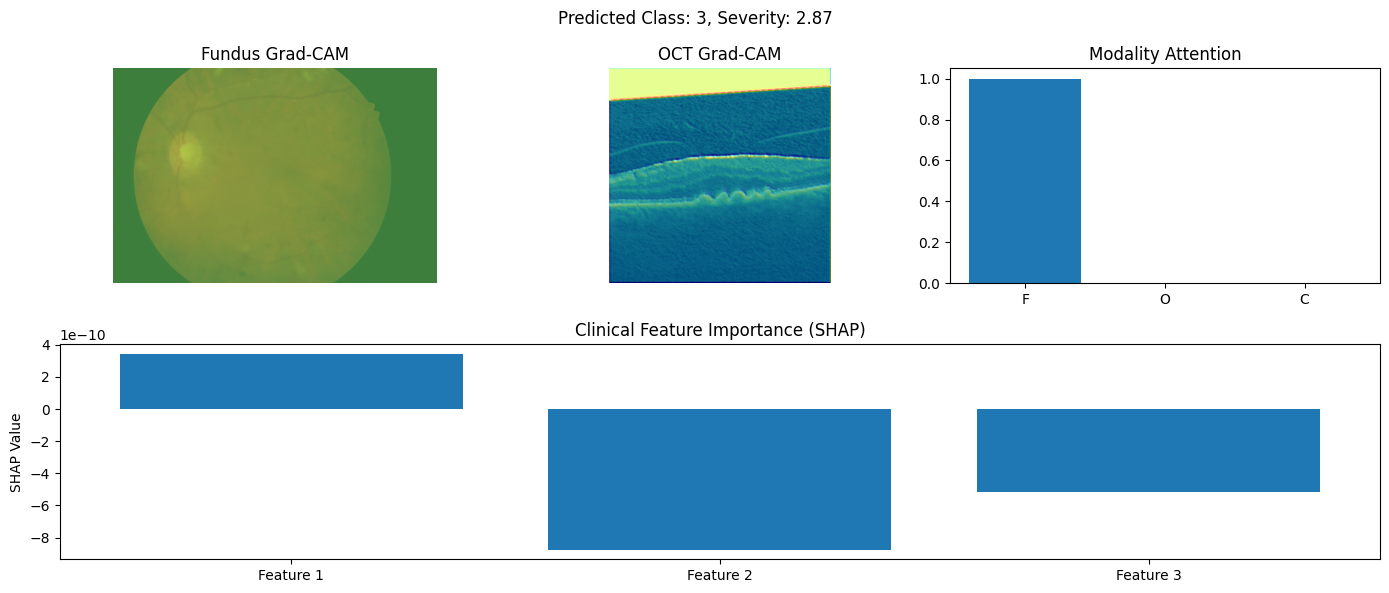

📊 Saved explainability plot as 'explainability_example.png'


<Figure size 640x480 with 0 Axes>

In [9]:
# ===============================
# 12️⃣ Load best model checkpoint
# ===============================
best_model = MultiModalNet(num_classes=num_classes, clinical_features=3).to(device)
best_model.load_state_dict(torch.load("best_multimodal_model.pth", map_location=device))
best_model.eval()
print("✅ Loaded best model for inference and demo.")

# ===============================
# 13️⃣ Gradio Interactive Demo
# ===============================
import gradio as gr

def predict_and_visualize(fundus_img, oct_img, age, sugar, bp):
    clinical_sample = [age, sugar, bp]
    f_tensor = image_transforms(fundus_img).unsqueeze(0).to(device)
    o_tensor = image_transforms(oct_img).unsqueeze(0).to(device)
    c_tensor = torch.tensor([clinical_sample], dtype=torch.float32).to(device)

    # Model prediction
    with torch.no_grad():
        cls_out, sev_out = best_model(f_tensor, o_tensor, c_tensor)
        pred_class = cls_out.argmax(dim=1).item()
        severity = float(sev_out.item())

    # Class mapping (adjust as per dataset)
    disease_map = {i: f"Class {i}" for i in range(num_classes)}
    disease = disease_map.get(pred_class, "Unknown")

    # Visualization
    visualize_explainability(fundus_img, oct_img, clinical_sample,
                             best_model, gradcam_fundus, gradcam_oct)

    return disease, severity

demo = gr.Interface(
    fn=predict_and_visualize,
    inputs=[
        gr.Image(type="numpy", label="Fundus Image"),
        gr.Image(type="numpy", label="OCT Image"),
        gr.Number(label="Age"),
        gr.Number(label="Blood Sugar"),
        gr.Number(label="Blood Pressure"),
    ],
    outputs=[
        gr.Textbox(label="Predicted Disease"),
        gr.Number(label="Predicted Severity"),
    ],
    title="🩺 Multi-Modal Retinal Disease Diagnosis (Fundus + OCT + Clinical)",
    description="Upload Fundus + OCT images, enter clinical values, and get predictions with Grad-CAM & SHAP explanations."
)

# Uncomment this to launch Gradio in Kaggle/Colab
#demo.launch(share=True)

# ===============================
# 14️⃣ (Optional) Save Example Visualization
# ===============================
fundus_example = cv2.imread(train_paths_f[0])[:,:,::-1]
oct_example = cv2.imread(train_paths_o[0])[:,:,::-1]
clinical_example = train_clin[0]

plt.figure()
visualize_explainability(fundus_example, oct_example, clinical_example,
                         best_model, gradcam_fundus, gradcam_oct)
plt.savefig("explainability_example.png")
print("📊 Saved explainability plot as 'explainability_example.png'")


In [10]:
# ===============================
# 14️⃣ Create Test Split & Loader
# ===============================
from sklearn.model_selection import train_test_split

# First split: Train vs Temp (Val+Test)
train_paths_f, temp_paths_f, train_paths_o, temp_paths_o, train_clin, temp_clin, train_labels, temp_labels = train_test_split(
    fundus_paths, oct_paths, clinical_data, labels, test_size=0.3, random_state=42, stratify=labels
)

# Second split: Temp into Val vs Test
val_paths_f, test_paths_f, val_paths_o, test_paths_o, val_clin, test_clin, val_labels, test_labels = train_test_split(
    temp_paths_f, temp_paths_o, temp_clin, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"📂 Train: {len(train_paths_f)} | Val: {len(val_paths_f)} | Test: {len(test_paths_f)}")

# Create datasets
train_dataset = MultiModalDataset(train_paths_f, train_paths_o, train_clin, train_labels, transform=image_transforms)
val_dataset   = MultiModalDataset(val_paths_f, val_paths_o, val_clin, val_labels, transform=image_transforms)
test_dataset  = MultiModalDataset(test_paths_f, test_paths_o, test_clin, test_labels, transform=image_transforms)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


📂 Train: 318 | Val: 68 | Test: 69


🔎 Evaluating best model on test set...

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889        20
           1     0.0000    0.0000    0.0000         3
           2     0.8800    0.9167    0.8980        24
           3     0.6250    0.7692    0.6897        13
           4     1.0000    0.3333    0.5000         9

    accuracy                         0.7971        69
   macro avg     0.6610    0.6038    0.5953        69
weighted avg     0.7862    0.7971    0.7651        69



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


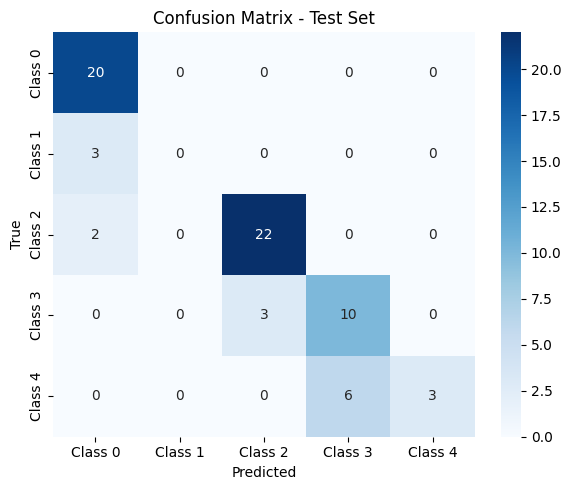

In [11]:
# ===============================
# 15️⃣ Final Evaluation on Test Set
# ===============================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("🔎 Evaluating best model on test set...")

best_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for f,o,c,y in test_loader:
        f, o, c, y = f.to(device), o.to(device), c.to(device), y.to(device)
        cls_out, _ = best_model(f,o,c)
        preds = cls_out.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


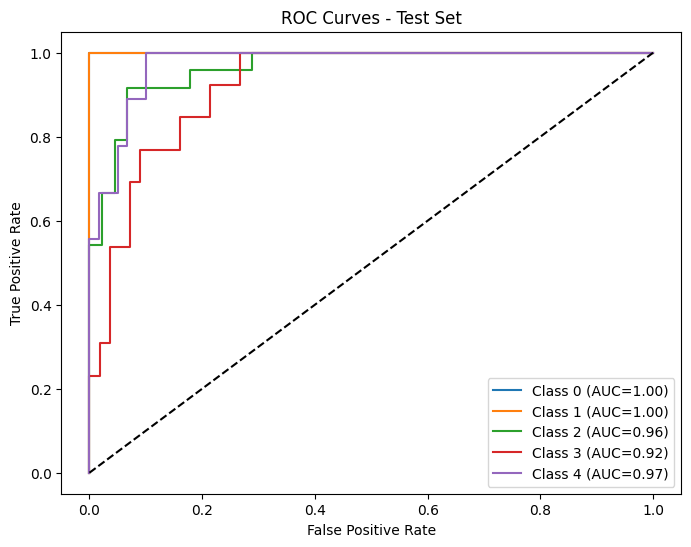

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Run evaluation again but store probabilities
all_labels, all_preds, all_probs = [], [], []

best_model.eval()
with torch.no_grad():
    for f, o, c, y in test_loader:
        f, o, c, y = f.to(device), o.to(device), c.to(device), y.to(device)
        cls_out, _ = best_model(f,o,c)
        probs = F.softmax(cls_out, dim=1).cpu().numpy()
        
        all_probs.append(probs)
        all_preds.append(probs.argmax(axis=1))
        all_labels.append(y.cpu().numpy())

all_probs  = np.vstack(all_probs)
all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# 🔎 ROC–AUC per class
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 📊 Plot
plt.figure(figsize=(8,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend()
plt.show()


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


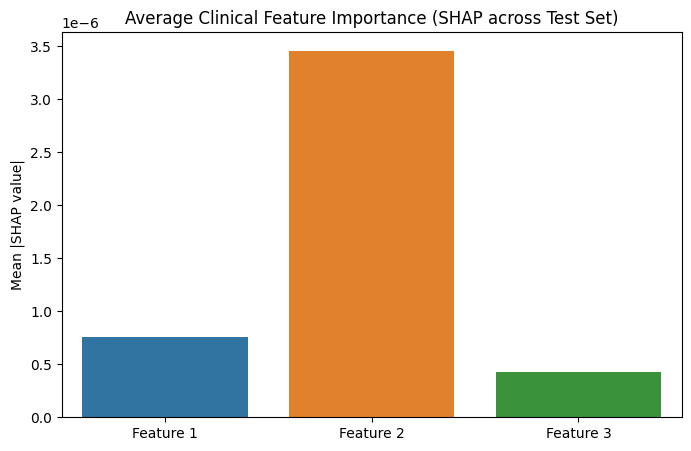

In [15]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

best_model.eval()

all_shap_values = []
all_preds = []
all_labels = []
all_shap_values = []
num_perturb = 20  # reduce for speed


with torch.no_grad():
    for f, o, c, y in test_loader:
        f, o, c, y = f.to(device), o.to(device), c.to(device), y.to(device)
        batch_size = f.size(0)

        for i in range(batch_size):
            f_sample = f[i:i+1]
            o_sample = o[i:i+1]
            c_sample = c[i].cpu().numpy()

            # Perturb clinical features
            c_batch = np.tile(c_sample, (num_perturb, 1))
            c_batch += np.random.normal(0, 1e-1, c_batch.shape)

            # Forward function for SHAP
            def model_forward(clinical_inputs):
                c_tensor = torch.tensor(clinical_inputs, dtype=torch.float32).to(device)
                cls_out, _ = best_model(f_sample.repeat(c_tensor.size(0),1,1,1),
                                        o_sample.repeat(c_tensor.size(0),1,1,1),
                                        c_tensor)
                return cls_out.cpu().numpy()

            explainer = shap.Explainer(model_forward, c_batch)
            shap_vals = explainer(c_batch)
            all_shap_values.append(shap_vals.values)

# Combine all SHAP values
all_shap_values = np.concatenate(all_shap_values, axis=0)


# Aggregate feature importance
mean_abs_shap = np.abs(all_shap_values).mean(axis=0).mean(axis=1)
feature_names = [f"Feature {i+1}" for i in range(mean_abs_shap.shape[0])]

plt.figure(figsize=(8,5))
sns.barplot(x=feature_names, y=mean_abs_shap)
plt.title("Average Clinical Feature Importance (SHAP across Test Set)")
plt.ylabel("Mean |SHAP value|")
plt.show()


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


📊 Saved SHAP plot as 'clinical_shap_testset.png'


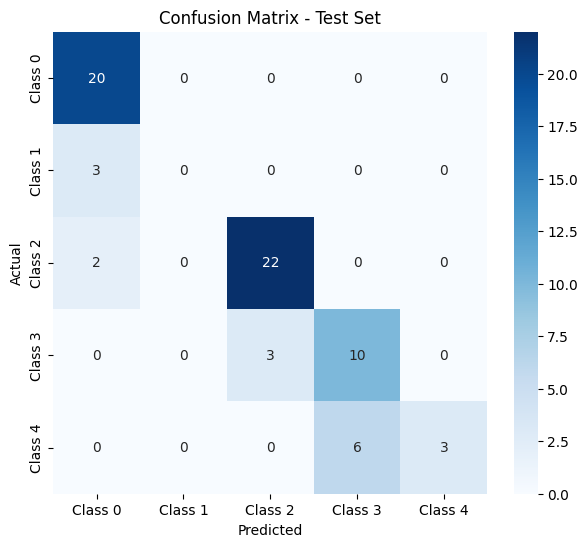

📊 Saved confusion matrix as 'confusion_matrix_testset.png'

Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889        20
           1     0.0000    0.0000    0.0000         3
           2     0.8800    0.9167    0.8980        24
           3     0.6250    0.7692    0.6897        13
           4     1.0000    0.3333    0.5000         9

    accuracy                         0.7971        69
   macro avg     0.6610    0.6038    0.5953        69
weighted avg     0.7862    0.7971    0.7651        69

📂 Saved test predictions as 'test_predictions.csv'


ExactExplainer explainer: 51it [00:31,  1.07it/s]                        


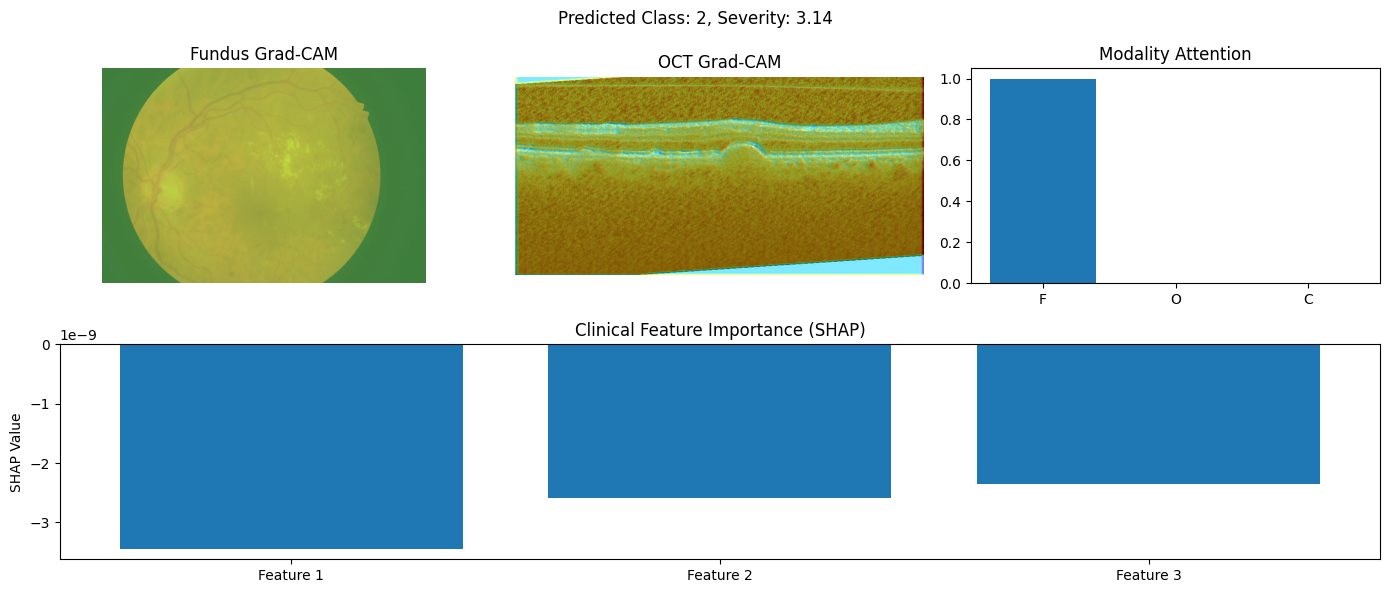

ExactExplainer explainer: 51it [00:34,  1.02it/s]                        


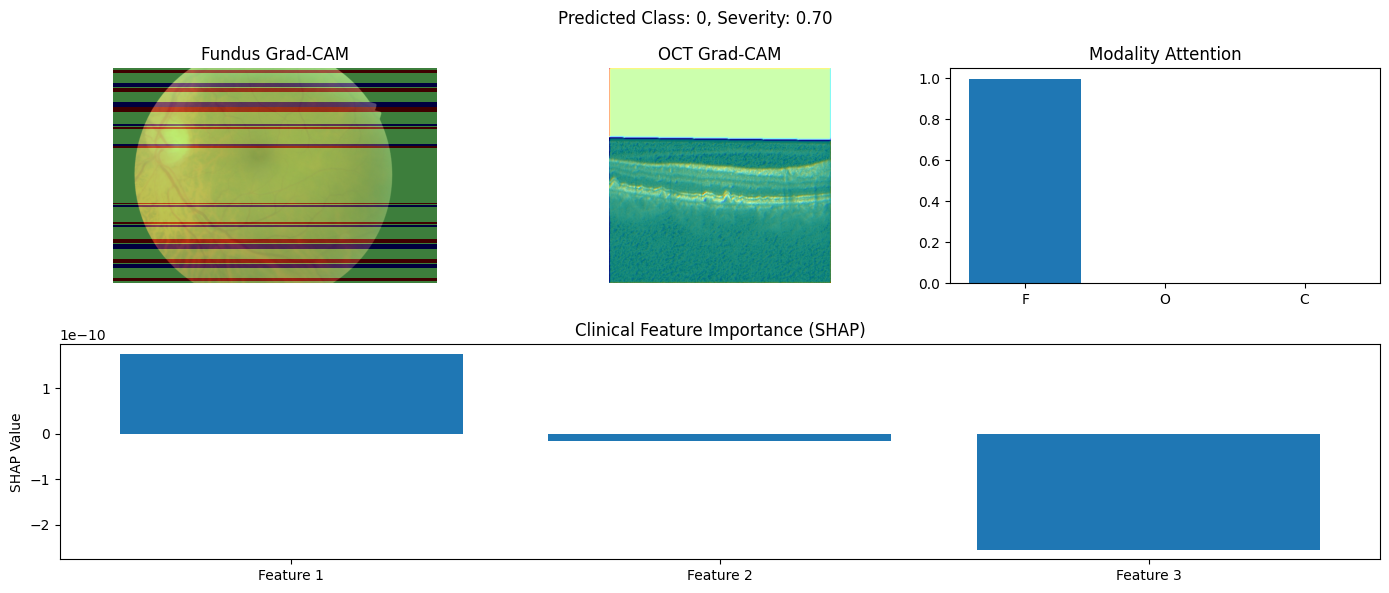

ExactExplainer explainer: 51it [00:32,  1.07it/s]                        


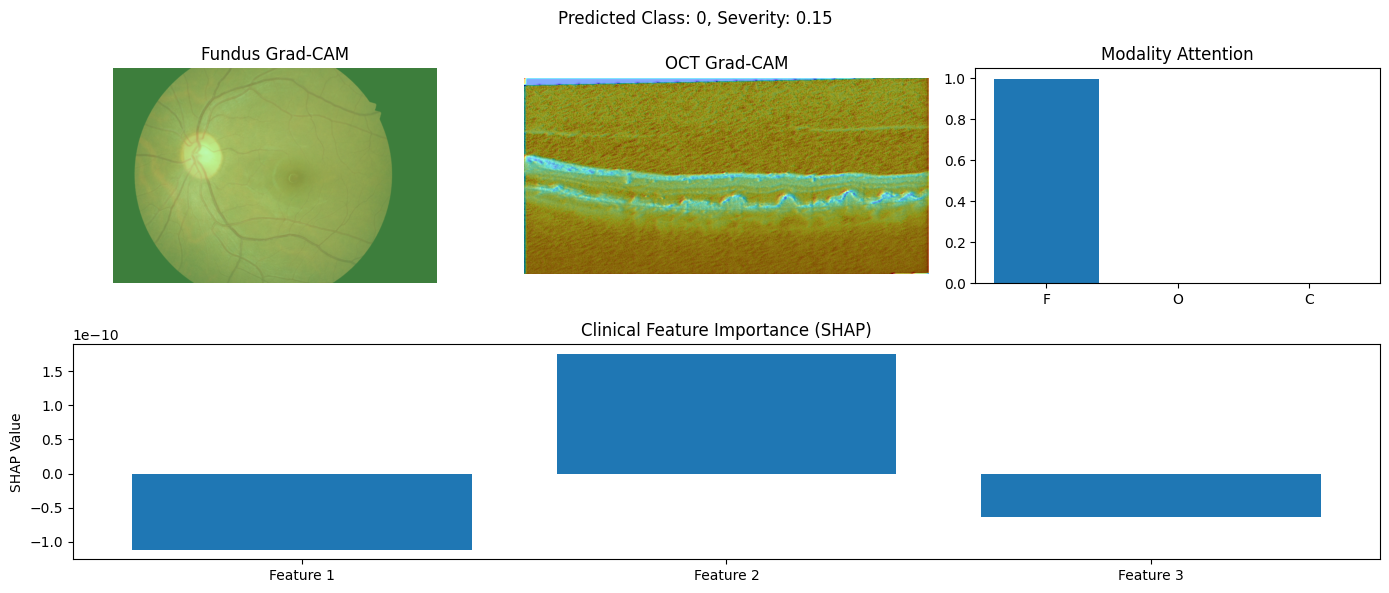

In [17]:
# ===============================
# 1️⃣ Ensure test predictions are populated
# ===============================
import numpy as np
import torch

best_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for f, o, c, y in test_loader:
        f, o, c, y = f.to(device), o.to(device), c.to(device), y.to(device)
        cls_out, _ = best_model(f, o, c)
        preds = cls_out.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Convert to np.array
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ===============================
# 2️⃣ Save SHAP feature importance plot
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=feature_names, y=mean_abs_shap)
plt.title("Average Clinical Feature Importance (SHAP across Test Set)")
plt.ylabel("Mean |SHAP value|")
plt.savefig("clinical_shap_testset.png")
plt.close()
print("📊 Saved SHAP plot as 'clinical_shap_testset.png'")

# ===============================
# 3️⃣ Confusion Matrix & Per-Class Metrics
# ===============================
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("confusion_matrix_testset.png")
plt.show()
print("📊 Saved confusion matrix as 'confusion_matrix_testset.png'")

print("\nClassification Report on Test Set:")
print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

# ===============================
# 4️⃣ Save test predictions for reporting / submission
# ===============================
import pandas as pd

submission_df = pd.DataFrame({
    "id_code": [os.path.basename(p).split('.')[0] for p in test_paths_f],
    "predicted_class": all_preds
})
submission_df.to_csv("test_predictions.csv", index=False)
print("📂 Saved test predictions as 'test_predictions.csv'")

# ===============================
# 5️⃣ Optional: Visualize Grad-CAM & SHAP for a few test samples
# ===============================
import cv2

num_samples_to_visualize = min(3, len(test_paths_f))  # ensure we don't exceed dataset size

for idx in range(num_samples_to_visualize):
    f_img = cv2.imread(test_paths_f[idx])[:, :, ::-1]  # BGR to RGB
    o_img = cv2.imread(test_paths_o[idx])[:, :, ::-1]
    c_sample = test_clin[idx]

    visualize_explainability(
        fundus_img=f_img,
        oct_img=o_img,
        clinical_sample=c_sample,
        model=best_model,
        gradcam_f=gradcam_fundus,
        gradcam_o=gradcam_oct
    )


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


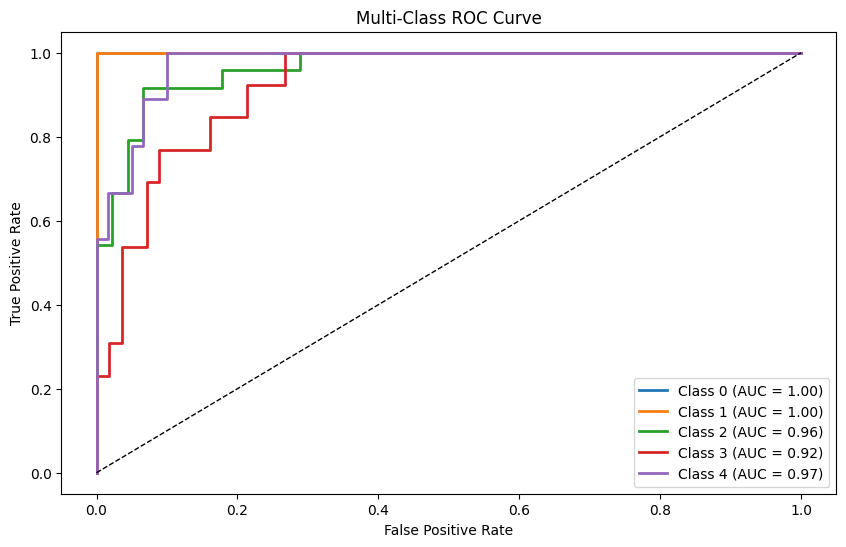

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
y_true = np.array(all_labels)
y_score = np.vstack([F.softmax(torch.tensor(best_model(
    f.to(device), o.to(device), torch.tensor(c, dtype=torch.float32).to(device)
)[0])).cpu().numpy() for f, o, c, _ in test_loader])

y_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(10,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [20]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(fundus_paths)):
    print(f"\n--- Fold {fold+1} ---")
    train_ds = MultiModalDataset([fundus_paths[i] for i in train_idx],
                                 [oct_paths[i] for i in train_idx],
                                 clinical_data[train_idx],
                                 np.array(labels)[train_idx],
                                 transform=image_transforms)
    val_ds = MultiModalDataset([fundus_paths[i] for i in val_idx],
                               [oct_paths[i] for i in val_idx],
                               clinical_data[val_idx],
                               np.array(labels)[val_idx],
                               transform=image_transforms)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

    # Reset model
    fold_model = MultiModalNet(num_classes=num_classes, clinical_features=3).to(device)
    optimizer = torch.optim.Adam(fold_model.parameters(), lr=1e-4)
    
    # Train 3 epochs for demo
    for epoch in range(3):
        fold_model.train()
        for f, o, c, y in train_loader:
            f, o, c, y = f.to(device), o.to(device), c.to(device), y.to(device)
            optimizer.zero_grad()
            cls_pred, sev_pred = fold_model(f,o,c)
            loss = multi_task_loss(cls_pred, sev_pred, y, y.float())
            loss.backward(); optimizer.step()
    
    # Evaluate
    fold_model.eval()
    all_preds, all_labels_fold = [], []
    with torch.no_grad():
        for f, o, c, y in val_loader:
            f, o, c, y = f.to(device), o.to(device), c.to(device), y.to(device)
            cls_out, _ = fold_model(f,o,c)
            all_preds.extend(cls_out.argmax(dim=1).cpu().numpy())
            all_labels_fold.extend(y.cpu().numpy())
    print(classification_report(all_labels_fold, all_preds, digits=4, zero_division=0))



--- Fold 1 ---
              precision    recall  f1-score   support

           0     0.3750    0.1304    0.1935        23
           1     0.0000    0.0000    0.0000         2
           2     0.4217    0.9459    0.5833        37
           3     0.0000    0.0000    0.0000        15
           4     0.0000    0.0000    0.0000        14

    accuracy                         0.4176        91
   macro avg     0.1593    0.2153    0.1554        91
weighted avg     0.2662    0.4176    0.2861        91


--- Fold 2 ---
              precision    recall  f1-score   support

           0     0.7407    0.8696    0.8000        23
           1     0.0000    0.0000    0.0000         6
           2     0.5135    0.6552    0.5758        29
           3     0.6667    0.3529    0.4615        17
           4     0.5556    0.6250    0.5882        16

    accuracy                         0.6044        91
   macro avg     0.4953    0.5005    0.4851        91
weighted avg     0.5731    0.6044    0.5753  

In [21]:
from itertools import product

param_grid = {
    "lr": [1e-3, 1e-4],
    "batch_size": [8, 16],
    "epochs": [3, 5]
}

best_acc = 0
best_params = {}

for lr, batch_size, epochs in product(param_grid['lr'], param_grid['batch_size'], param_grid['epochs']):
    print(f"Testing lr={lr}, batch_size={batch_size}, epochs={epochs}")
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    temp_model = MultiModalNet(num_classes=num_classes, clinical_features=3).to(device)
    optimizer = torch.optim.Adam(temp_model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        temp_model.train()
        for f,o,c,y in train_loader:
            f,o,c,y = f.to(device), o.to(device), c.to(device), y.to(device)
            optimizer.zero_grad()
            cls_pred, sev_pred = temp_model(f,o,c)
            loss = multi_task_loss(cls_pred, sev_pred, y, y.float())
            loss.backward(); optimizer.step()
    
    # Evaluate
    temp_model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for f,o,c,y in val_loader:
            f,o,c,y = f.to(device), o.to(device), c.to(device), y.to(device)
            cls_out,_ = temp_model(f,o,c)
            correct += (cls_out.argmax(dim=1) == y).sum().item()
            total += y.size(0)
    acc = correct/total
    if acc > best_acc:
        best_acc = acc
        best_params = {"lr": lr, "batch_size": batch_size, "epochs": epochs}
print("Best Hyperparameters:", best_params)


Testing lr=0.001, batch_size=8, epochs=3
Testing lr=0.001, batch_size=8, epochs=5
Testing lr=0.001, batch_size=16, epochs=3
Testing lr=0.001, batch_size=16, epochs=5
Testing lr=0.0001, batch_size=8, epochs=3
Testing lr=0.0001, batch_size=8, epochs=5
Testing lr=0.0001, batch_size=16, epochs=3
Testing lr=0.0001, batch_size=16, epochs=5
Best Hyperparameters: {'lr': 0.0001, 'batch_size': 16, 'epochs': 5}


In [22]:
def predict_and_explain(fundus_img_path, oct_img_path, clinical_features):
    fundus_img = cv2.imread(fundus_img_path)[:,:,::-1]
    oct_img = cv2.imread(oct_img_path)[:,:,::-1]
    clinical_features = np.array(clinical_features, dtype=np.float32)
    
    # Tensor
    f_tensor = image_transforms(fundus_img).unsqueeze(0).to(device)
    o_tensor = image_transforms(oct_img).unsqueeze(0).to(device)
    c_tensor = torch.tensor([clinical_features], dtype=torch.float32).to(device)
    
    best_model.eval()
    with torch.no_grad():
        cls_out, sev_out = best_model(f_tensor, o_tensor, c_tensor)
        pred_class = cls_out.argmax(dim=1).item()
        severity = sev_out.item()
    
    # Explainability
    shap_vals, feature_names = shap_clinical(best_model, f_tensor, o_tensor, clinical_features)
    
    return {"predicted_class": pred_class,
            "predicted_severity": severity,
            "shap_values": shap_vals,
            "feature_names": feature_names}


In [24]:
from sklearn.metrics import f1_score, cohen_kappa_score, balanced_accuracy_score
import numpy as np
import torch

# Ensure model is in eval mode
best_model.eval()

all_preds = []
all_labels = []

# Generate predictions
with torch.no_grad():
    for f, o, c, y in test_loader:
        f, o, c, y = f.to(device), o.to(device), c.to(device), y.to(device)
        cls_out, _ = best_model(f, o, c)
        preds = cls_out.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Verify lengths match
assert len(y_true) == len(y_pred), f"Mismatch: {len(y_true)} labels vs {len(y_pred)} predictions"

# Compute metrics
macro_f1 = f1_score(y_true, y_pred, average='macro')
micro_f1 = f1_score(y_true, y_pred, average='micro')
kappa = cohen_kappa_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Micro F1-score: {micro_f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")


Macro F1-score: 0.5953
Micro F1-score: 0.7971
Cohen's Kappa: 0.7180
Balanced Accuracy: 0.6038
